# Data Dictionary

|Attribute|Description
----------|-----------
InvoiceNo| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode| Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description| Product (item) name. Nominal.
Quantity| The quantities of each product (item) per transaction. Numeric.
InvoiceDate| Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice| Unit price. Numeric, Product price per unit in sterling.
CustomerID| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country| Country name. Nominal, the name of the country where each customer resides.

# 0.0 Imports

In [1]:
import pandas as pd
import inflection
from src import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics as mt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.manifold as man
#import umap as um
import umap.umap_ as um

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid')

# 0.1 Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 1.0. Data Description

In [5]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [6]:
df_description.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Renaming Columns

In [7]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [8]:
df_description['description'] = df_description['description'].str.lower()

In [9]:
df_description.sort_values(['invoice_date', 'description'])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
143414,548701,23007,spaceboy baby gift set,1,1-Apr-17,16.95,17629.0,United Kingdom
143694,548711,22906,12 message cards with envelopes,2,1-Apr-17,1.65,18116.0,United Kingdom
144000,548715,22906,12 message cards with envelopes,6,1-Apr-17,1.65,17758.0,United Kingdom
143573,548708,84461,12 pink hen+chicks in basket,1,1-Apr-17,2.55,13269.0,United Kingdom
144035,548715,21457,2 picture book eggs easter ducks,6,1-Apr-17,1.25,17758.0,United Kingdom
...,...,...,...,...,...,...,...,...
335644,566290,84836,zinc metal heart decoration,2,9-Sep-17,1.25,14456.0,United Kingdom
335748,566291,84836,zinc metal heart decoration,3,9-Sep-17,1.25,12965.0,United Kingdom
335588,566290,23153,zinc sweetheart wire letter rack,2,9-Sep-17,3.75,14456.0,United Kingdom
334150,566233,23145,zinc t-light holder star large,12,9-Sep-17,0.95,12635.0,Germany


## 1.2. Data Dimension

In [10]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [11]:
gu.sum_table(df_description)

,Name,dtypes,Uniques,Missing,Missing %
0,invoice_no,object,25900,0,0.00
1,stock_code,object,4070,0,0.00
2,description,object,4206,1454,0.27
3,quantity,int64,722,0,0.00
4,invoice_date,object,305,0,0.00
5,unit_price,float64,1630,0,0.00
6,customer_id,float64,4372,135080,24.93
7,country,object,38,0,0.00


## 1.4.  Handling Missing Values

Checking if there are invoice number of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [12]:
invoice_no_of_missing_customer_ids = df_description.query('customer_id.isnull()').invoice_no.values

In [100]:
df_description.loc[df_description['invoice_no'].isin(invoice_no_of_missing_customer_ids)].sort_values(['quantity', 'description', ]).head(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
225529,556690,23005,printing smudges/thrown away,-9600,12-Jun-17,0.0,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,12-Jun-17,0.0,NaN,United Kingdom
225528,556687,23003,printing smudges/thrown away,-9058,12-Jun-17,0.0,NaN,United Kingdom
115818,546152,72140F,throw away,-5368,7-Mar-17,0.0,NaN,United Kingdom
431381,573596,79323W,"unsaleable, destroyed.",-4830,29-Oct-17,0.0,NaN,United Kingdom


There are some weird stuff in this dataset.

Negative quantities:

- Invoice_no with 'C' are cancellations.
- There are some elements without the C code that have negative quantities.

Descriptions like "thrown away", "unsalable, destroyde"

Unit price 0.0

**Negative Quantity That are not cancellations**

In [102]:
df_description.query("quantity <= 0 & invoice_no.str.isdigit()").sort_values('quantity').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
225530,556691,23005,printing smudges/thrown away,-9600,12-Jun-17,0.0,NaN,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,12-Jun-17,0.0,NaN,United Kingdom
225528,556687,23003,printing smudges/thrown away,-9058,12-Jun-17,0.0,NaN,United Kingdom
115818,546152,72140F,throw away,-5368,7-Mar-17,0.0,NaN,United Kingdom
431381,573596,79323W,"unsaleable, destroyed.",-4830,29-Oct-17,0.0,NaN,United Kingdom


In [99]:
df_description.query("quantity <= 0 & invoice_no.str.isdigit()").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336 entries, 2406 to 538919
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    1336 non-null   object 
 1   stock_code    1336 non-null   object 
 2   description   474 non-null    object 
 3   quantity      1336 non-null   int64  
 4   invoice_date  1336 non-null   object 
 5   unit_price    1336 non-null   float64
 6   customer_id   0 non-null      float64
 7   country       1336 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 93.9+ KB


Every customer_id is null. Elements with negative values for quantities that are not a cancellation must be an error or a problem with the product. We must remove these instances from the dataset.

In [104]:
#df_description.query("~(quantity <= 0 & invoice_no.str.isdigit())")

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,29-Nov-16,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,7-Dec-17,0.85,12680.0,France
541905,581587,22899,children's apron dolly girl,6,7-Dec-17,2.10,12680.0,France
541906,581587,23254,childrens cutlery dolly girl,4,7-Dec-17,4.15,12680.0,France
541907,581587,23255,childrens cutlery circus parade,4,7-Dec-17,4.15,12680.0,France


**Cancellations**

In [111]:
df_cancellations = df_description.query("invoice_no.str.contains('C')")#.customer_id.unique()
df_cancellations.isnull().sum()

invoice_no        0
stock_code        0
description       0
quantity          0
invoice_date      0
unit_price        0
customer_id     383
country           0
dtype: int64

In [113]:
df_cancellations.quantity.max()

-1

In [122]:
df_cancel_wo_id = df_cancellations.query("customer_id.isnull()")

Can we recover the customer ID for these instances?

In [127]:
df_cancel_wo_id['quantity'] = df_cancel_wo_id['quantity'].apply(lambda x: -x)

C:\Users\Bteix\AppData\Local\Temp\ipykernel_14376\679165250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancel_wo_id['quantity'] = df_cancel_wo_id['quantity'].apply(lambda x: -x)


In [118]:
df_transactions = df_description.query('quantity > 0')

merged = df_transactions.merge(df_cancel_wo_id, on=['stock_code', 'quantity', 'unit_price', 'country'], how='left').query('~invoice_no_y.isnull()')
# Picking the elements that only have a unique correspondent.
unique_sto_code = merged.groupby('stock_code').count().reset_index().query('invoice_no_x == 1').stock_code

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531285 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    531285 non-null  object 
 1   stock_code    531285 non-null  object 
 2   description   530693 non-null  object 
 3   quantity      531285 non-null  int64  
 4   invoice_date  531285 non-null  object 
 5   unit_price    531285 non-null  float64
 6   customer_id   397924 non-null  float64
 7   country       531285 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.5+ MB


In [160]:
# Selecting elements where the customer id is not null
merged.loc[merged['stock_code'].isin(unique_sto_code) & ~merged['customer_id_x'].isnull()]

,invoice_no_x,stock_code,description_x,quantity,invoice_date_x,unit_price,customer_id_x,country,invoice_no_y,description_y,invoice_date_y,customer_id_y
95405,544634,21826,eight piece dinosaur set,4,20-Feb-17,1.25,17994.0,United Kingdom,C537251,eight piece dinosaur set,4-Dec-16,NaN
439450,575070,22053,empire design rosette,1,6-Nov-17,1.25,17841.0,United Kingdom,C553854,empire design rosette,17-May-17,NaN
452373,575954,22454,measuring tape babushka red,8,11-Nov-17,2.95,17211.0,United Kingdom,C537251,measuring tape babushka red,4-Dec-16,NaN


In [163]:
#df_description.query("~(invoice_no.str.contains('C') & customer_id.isnull())")

Only three unique correspondents have a customer id. But if we look at the date, the date of the cancellation is before the date of the transaction, which doesn't make sense.
Therefore, I will remove the cancellation instances that don't have a customer id.

In [167]:
df_transactions.isnull().sum()

invoice_no           0
stock_code           0
description        592
quantity             0
invoice_date         0
unit_price           0
customer_id     133361
country              0
dtype: int64

In [164]:
inv_no_missing_customers = df_transactions.query('customer_id.isnull()').invoice_no.unique()
stock_code_missing_customers = df_transactions.query('customer_id.isnull()').stock_code.unique()

In [165]:
invoice_no_of_missing_customer_ids = df_description.query('customer_id.isnull()').invoice_no.values
df_description.loc[df_description.invoice_date.isin(invoice_no_of_missing_customer_ids)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


I tried to find invoice numbers of instances with missing customer id in other parts of the dataset to fill in missing values, but none were found.

In [169]:
df_clean = df_description.query("~(quantity <= 0 & invoice_no.str.isdigit())")
df_clean = df_clean.query("~(invoice_no.str.contains('C') & customer_id.isnull())")
df_clean = df_clean.query("~customer_id.isnull()")

In [172]:
df_clean.sort_values('quantity')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540422,C581484,23843,"paper craft , little birdie",-80995,7-Dec-17,2.08,16446.0,United Kingdom
61624,C541433,23166,medium ceramic top storage jar,-74215,16-Jan-17,1.04,12346.0,United Kingdom
4287,C536757,84347,rotating silver angels t-light hldr,-9360,30-Nov-16,0.03,15838.0,United Kingdom
160145,C550456,21108,fairy cake flannel assorted colour,-3114,16-Apr-17,2.10,15749.0,United Kingdom
160144,C550456,21175,gin + tonic diet metal sign,-2000,16-Apr-17,1.85,15749.0,United Kingdom
...,...,...,...,...,...,...,...,...
421632,573008,84077,world war 2 gliders asstd designs,4800,25-Oct-17,0.21,12901.0,United Kingdom
74614,542504,37413,NaN,5568,26-Jan-17,0.00,NaN,United Kingdom
502122,578841,84826,asstd design 3d paper stickers,12540,23-Nov-17,0.00,13256.0,United Kingdom
61619,541431,23166,medium ceramic top storage jar,74215,16-Jan-17,1.04,12346.0,United Kingdom


In [185]:
# description
print(f'Removed data: {1 - (df_clean.shape[0]/df_description.shape[0]):.3%}')
print(f'Number of Elements Removed: {df_description.shape[0] - df_clean.shape[0]}')

Removed data: 24.927%
Number of Elements Removed: 135080


In [184]:
df_clean.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [16]:
df_description.shape[0]

406829

## 1.5. Fixing Data Types

In [186]:
df_clean.invoice_date = pd.to_datetime(df_clean.invoice_date)
df_clean.customer_id = df_clean.customer_id.astype(int)

C:\Users\Bteix\AppData\Local\Temp\ipykernel_14376\1308533011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.invoice_date = pd.to_datetime(df_clean.invoice_date)
C:\Users\Bteix\AppData\Local\Temp\ipykernel_14376\1308533011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.customer_id = df_clean.customer_id.astype(int)


In [187]:
df_clean.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,17850,United Kingdom


In [189]:
df_clean.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.6. Descriptive Statistics

### 1.6.1 Numerical Attributes

In [190]:
num_att = df_clean.select_dtypes(include=['float64', 'int64'])
cat_att = df_clean.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [191]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,min,max,range,mean,median,var,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,61848.392291,248.693370,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,4804.591645,69.315162,452.219019,246924.542988


In [192]:
df_description.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997])[['quantity', 'unit_price']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,99.7%,max
quantity,541909.0,9.552250,218.081158,-80995.00,-2.00,1.00,1.00,1.00,3.00,12.00,24.00,29.00,100.0,240.00,80995.0
unit_price,541909.0,4.611114,96.759853,-11062.06,0.19,0.42,0.63,0.85,2.08,4.95,7.95,9.95,18.0,39.95,38970.0


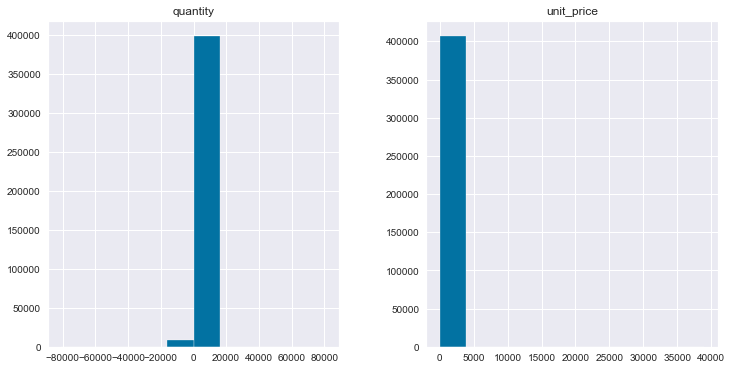

In [199]:
df_clean.drop(columns=['invoice_date', 'customer_id']).hist(figsize=(12, 6));

### <font color='red'> 1.6.2  Further Analysis needed </font>

Quantity with negative values -> What to do with cancellations.

Unit price 0 -> promotion? emove these values?


### 1.6.1 Categorical Attributes

**Invoice Number with at least one string**

In [200]:
# df_description.inoice_no.astype(int)
letter_invoices = df_clean.loc[df_description.invoice_no.str.contains('C')]

print('Total Number of Cancelation invoices:', len(letter_invoices))
print('Total Number of Negative quantites:', len(letter_invoices.query('quantity < 0')))

Total Number of Cancelation invoices: 8905
Total Number of Negative quantites: 8905


**Stock codes with at least one string**

In [201]:
df_clean.loc[~df_clean.stock_code.str.isdigit()].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,17850,United Kingdom
45,536370,POST,postage,3,2016-11-29,18.00,12583,France


In [202]:
df_clean.loc[df_clean.stock_code.str.isalpha()].stock_code.value_counts()
# Remove stovk_code in [POST, M, D, DOT, CRUK, PADS]

POST    1196
M        465
D         77
DOT       16
CRUK      16
PADS       4
Name: stock_code, dtype: int64

**Stock codes that are only strings**

In [203]:
df_clean.loc[df_clean.stock_code.str.isalpha()].head()

# delete Description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,postage,3,2016-11-29,18.00,12583,France
141,C536379,D,discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,postage,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,postage,1,2016-11-29,18.00,12662,Germany
2239,536569,M,manual,1,2016-11-29,1.25,16274,United Kingdom


In [205]:
df_clean.groupby('country').nunique()[['customer_id']].reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 3.0. Variables Filtering

In [206]:
df_filter = df_clean.copy()
columns = ['invoice_no', 'quantity', 'invoice_date', 'unit_price', 'customer_id']

## 3.1. Numerical

In [220]:
desc = df_filter[['customer_id', 'description', 'quantity', 'unit_price']].query('unit_price < 0.04').description.unique()#.sort_values('unit_price', ascending=False).head(10)

In [226]:
items_with_multiple_unit_prices = (df_filter.groupby('description').nunique()[['unit_price']] > 1).index

df_filter.loc[(df_filter['description'].isin(items_with_multiple_unit_prices)) & (df_filter['description'].isin(desc)) ].sort_values(['description', 'unit_price',]).head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
279324,561284,22167,oval wall mirror diamante,1,2017-07-24,0.00,16818,United Kingdom
174137,551747,22167,oval wall mirror diamante,24,2017-05-02,3.95,14298,United Kingdom
17467,537764,22167,oval wall mirror diamante,1,2016-12-06,9.95,16893,United Kingdom
29978,538839,22167,oval wall mirror diamante,1,2016-12-12,9.95,14606,United Kingdom
33094,539222,22167,oval wall mirror diamante,4,2016-12-14,9.95,14621,United Kingdom
33783,539294,22167,oval wall mirror diamante,3,2016-12-14,9.95,15532,United Kingdom
57388,541205,22167,oval wall mirror diamante,3,2017-01-12,9.95,18106,United Kingdom
63610,541585,22167,oval wall mirror diamante,2,2017-01-17,9.95,14180,United Kingdom
70900,542105,22167,oval wall mirror diamante,2,2017-01-23,9.95,12854,United Kingdom
71881,542216,22167,oval wall mirror diamante,2,2017-01-24,9.95,14911,EIRE


In [242]:
df_filter = df_filter.query('unit_price >= 0.04')

What to do if a customer has a negative spent overall. In this dataset the cancelation code doesn't match the transaction code.


idea for next cycle: compute the average unit price, or the mode, for each product (without the zero values) and fill the extremly low values with it.

## 3.2. Categorical

In [243]:
# removing stock_codes that are only letters
df_filter = df_filter.query("~stock_code.isin(['POST', 'M', 'D', 'DOT', 'CRUK', 'PADS'])")

# removing European Community and Unspecified
df_filter = df_filter.query("~country.isin(['European Community', 'Unspecified'])")

dict_country = {'EIRE': 'Ireland', 'RSA': 'South Africa'}
df_filter.country = df_filter.country.apply(lambda x: 'Ireland' if x == 'EIRE' else 'South Africa' if x == 'RSA' else x)

In [244]:
df_cancelation = df_filter.query("quantity < 0 or invoice_no.str.contains('C')")[columns]
df_transaction = df_filter.query('quantity > 0')[columns]

In [245]:
print('Number of rows Cancelation:', df_cancelation.shape[0])
print('Number of rows Transaction:', df_transaction.shape[0])

Number of rows Cancelation: 8538
Number of rows Transaction: 396180


In [246]:
df_cancelation.loc[df_cancelation.invoice_no.str.isdigit()]

,invoice_no,quantity,invoice_date,unit_price,customer_id


In [247]:
df_transaction.loc[~df_transaction.invoice_no.str.isdigit()]

,invoice_no,quantity,invoice_date,unit_price,customer_id


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 2.0. Feature Engineering

In [274]:
df_feature = df_filter.copy()
df_feature_transaction = df_transaction.copy()
df_feature_cancelation = df_cancelation.copy()

In [275]:
df_feature['gross_revenue'] = df_feature.quantity * df_feature.unit_price

# Recency
diff = df_filter.invoice_date.max() - df_feature_transaction.groupby('customer_id').max()['invoice_date']
recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

recency['recency'] = recency['recency'].dt.days
df_feature = df_feature.merge((recency), how='left', on='customer_id')


# Frequency
frequency = df_feature_transaction.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'frequency'})
df_feature = df_feature.merge((frequency), how='left', on='customer_id')


# Monetary
monetary = df_feature.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'monetary'})
df_feature = df_feature.merge((monetary), how='left', on='customer_id')

# Average Ticket
avg_ticket = df_feature.groupby('customer_id').mean(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_feature = df_feature.merge((avg_ticket), how='left', on='customer_id')

#

# Total Cancelation
#df_feature_cancelation['total_returned'] = -df_feature_cancelation.quantity * df_feature_cancelation.unit_price
#total_returned = df_feature_cancelation.groupby('customer_id').sum()[['total_returned']].reset_index()
#
#df_feature = df_feature.merge(total_returned, how='left', on='customer_id')
#
#cancelations = df_feature_cancelation.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'number_of_cancelations'})
#df_feature = df_feature.merge(cancelations, how='left', on='customer_id')

df_feature.isnull().sum()

invoice_no        0
stock_code        0
description       0
quantity          0
invoice_date      0
unit_price        0
customer_id       0
country           0
gross_revenue     0
recency          84
frequency        84
monetary          0
avg_ticket        0
dtype: int64

Some element only have cancellations, they need to be removed.

In [276]:
#df_feature_transaction.fillna(0, inplace=True)

In [277]:
columns = ['customer_id', 'recency', 'frequency', 'monetary', 'avg_ticket']
df_customers = df_feature.drop_duplicates('customer_id').copy()[columns]
df_customers.head()

,customer_id,recency,frequency,monetary,avg_ticket
0,17850,372.0,34.0,5288.63,16.950737
9,13047,56.0,9.0,3089.10,15.923196
26,12583,2.0,15.0,6629.34,28.209957
45,13748,95.0,5.0,948.25,33.866071
64,15100,333.0,3.0,635.10,105.850000


In [278]:
df_customers.query("~(monetary <= 0)").isnull().sum()

customer_id    0
recency        0
frequency      0
monetary       0
avg_ticket     0
dtype: int64

**For this cycle I will remove customers tha have a returned value above the monetary value.**

In [280]:
df_customers_clean = df_customers.query('~(monetary <= 0)')
print('Items Removed:', df_customers.query('(monetary <= 0)').shape[0])

Items Removed: 37


In [281]:
#removed = df_customers.query('(total_returned >= monetary)').shape[0]
#percent = removed/df_customers.shape[0]
# 
#print(f'Number of elements Removed: {removed}\nPercetual removed: {percent:.2%}')
#df_customers.query('~(total_returned >= monetary)')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 4.0. Exploratory Data Analysis

In [288]:
df_eda = df_customers_clean.copy()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 5.0. Data Preparation

In [289]:
df_prep = df_eda.copy()

In [292]:
std = Pipeline([('standard', pp.StandardScaler())])
minmax = Pipeline([('minmax', pp.MinMaxScaler())])
robust = Pipeline([('robust', pp.RobustScaler())])
cols = ['recency', 'frequency', 'monetary', 'avg_ticket']
pass_cols = ['customer_id'] 
preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('minmax', minmax, cols)])


In [293]:
#df_prep_scaled = 
df_prep_scaled = pd.DataFrame(preprocess.fit_transform(df_prep))

In [294]:
cols = ['customer_id', 'recency', 'frequency', 'monetary', 'avg_ticket']
df_prep_scaled.columns = cols

In [295]:
df_prep_scaled

,customer_id,recency,frequency,monetary,avg_ticket
0,17850.0,0.997319,0.160976,0.018971,0.001711
1,13047.0,0.150134,0.039024,0.011081,0.001608
2,12583.0,0.005362,0.068293,0.023780,0.002848
3,13748.0,0.254692,0.019512,0.003401,0.003419
4,15100.0,0.892761,0.009756,0.002278,0.010687
...,...,...,...,...,...
4315,13436.0,0.002681,0.000000,0.000706,0.001657
4316,15520.0,0.002681,0.000000,0.001232,0.001927
4317,13298.0,0.002681,0.000000,0.001291,0.018173
4318,14569.0,0.002681,0.000000,0.000816,0.001913


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 6.0. Feature Selection

In [296]:
df_fselect = df_prep.copy()[['customer_id',  'recency', 'frequency', 'monetary', 'avg_ticket']]
df_fselect_sc = df_prep_scaled.copy()[['customer_id',  'recency', 'frequency', 'monetary', 'avg_ticket']]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 7.0. Hyperparameter Fine-Tuning

In [297]:
df_k = df_fselect_sc[['customer_id', 'recency', 'frequency', 'monetary', 'avg_ticket']].drop(columns=['customer_id']).copy().reset_index(drop=True)

In [298]:
df_k.head()

,recency,frequency,monetary,avg_ticket
0,0.997319,0.160976,0.018971,0.001711
1,0.150134,0.039024,0.011081,0.001608
2,0.005362,0.068293,0.023780,0.002848
3,0.254692,0.019512,0.003401,0.003419
4,0.892761,0.009756,0.002278,0.010687


In [299]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Squares (WSS)

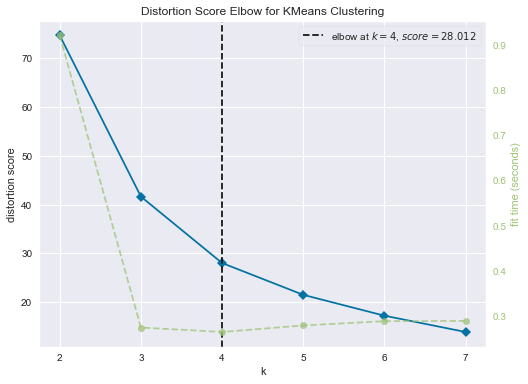

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [300]:
plt.figure(figsize=(8, 6))
kmeans = KMeans(init='random', n_init=10, max_iter=300, random_state=42)

vis = KElbowVisualizer(kmeans, k=clusters, timing=False)
vis.fit(df_k)
vis.show()

## 7.2 Sillhoutte Score

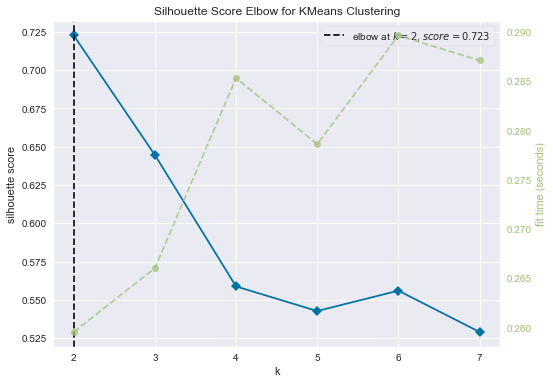

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [301]:
plt.figure(figsize=(8, 6))
kmeans = KMeans(init='random', n_init=10, max_iter=300, random_state=42)

vis = KElbowVisualizer(kmeans, k=clusters, metric='silhouette', timing=False)
vis.fit(df_k)
vis.show()

## 7.3 Sillhoutte Analysis

<Figure size 720x432 with 0 Axes>

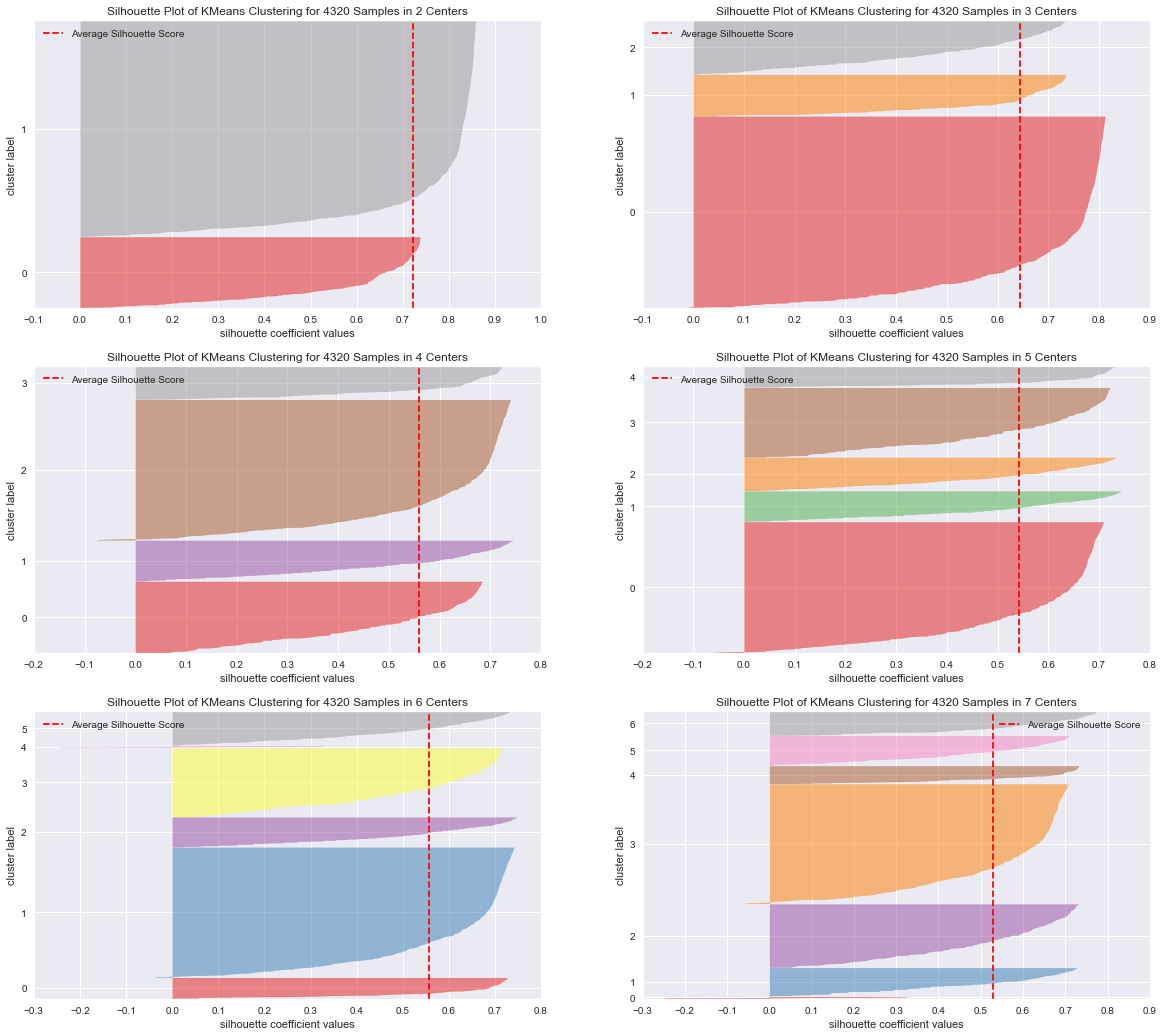

In [303]:
plt.figure(figsize=(10, 6))
n_clusters = [2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(3, 2, figsize=(20, 18))

for k in n_clusters:
    q, mod = divmod(k, 2)
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    vis = SilhouetteVisualizer(kmeans, color='yellowbricks', ax=ax[q-1][mod])
    vis.fit(df_k)
    vis.finalize()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Model Training

## 8.1. K-Means

In [304]:
# model
n_cluster=4
kmeans = KMeans(init='random', n_clusters=n_cluster, n_init=10, max_iter=300, random_state=42)

# model training
labels = kmeans.fit_predict(df_k)
ss = mt.silhouette_score(df_k, labels)
wss = kmeans.inertia_

print(f'Silhouette Score: {ss}')
print(f'Within CLuster Sum of Squares: {wss}')

Silhouette Score: 0.558828090807222
Within CLuster Sum of Squares: 28.012471650542796


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 9.0. Cluster Analysis

## 9.1. Visualization

In [305]:
cluster_df = df_fselect.copy()
cluster_df_sc = df_fselect_sc.copy()
cluster_df['cluster'] = labels
cluster_df_sc['cluster'] = labels

e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


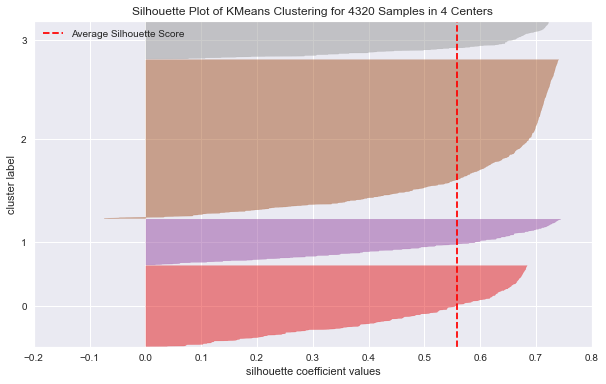

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4320 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [306]:
plt.figure(figsize=(10, 6))
vis = SilhouetteVisualizer(kmeans, color='yellowbricks')
vis.fit(df_k)
vis.show()

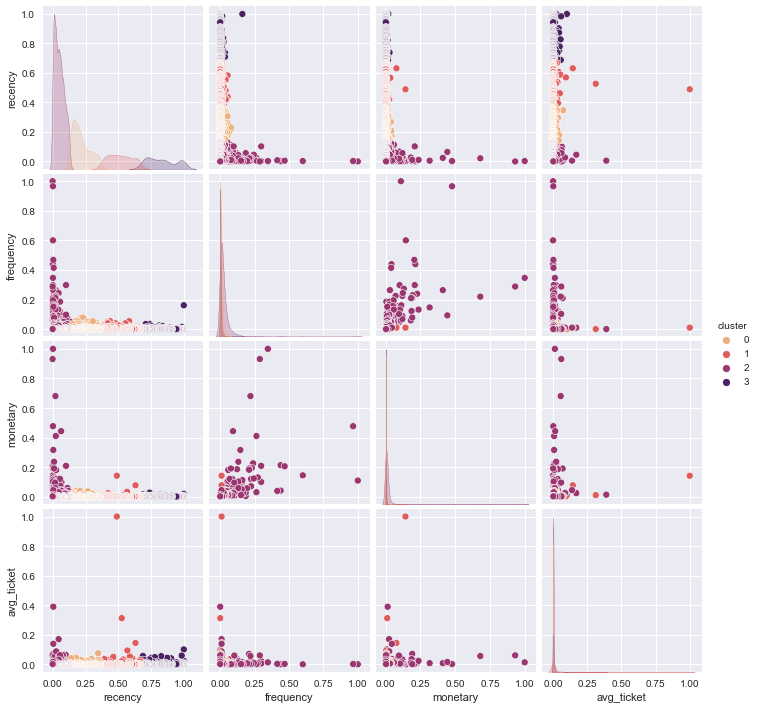

In [307]:
sns.pairplot(cluster_df_sc.drop(columns='customer_id'), hue='cluster', palette='flare')

In [308]:
X = df_fselect_sc.copy().drop(columns='customer_id')

# TSNE
tsne = man.TSNE(random_state=42, perplexity=50)

features_tsne = tsne.fit_transform(X)

#tsne_scaled = man.TSNE(random_state=42)
#
#features_tsne_scaled = tsne.fit_transform(X_scaled)

In [309]:
# UMAP

u_map = um.UMAP(n_neighbors=50, random_state=42)

X_umap = u_map.fit_transform(X)

## TSNE

<AxesSubplot:>

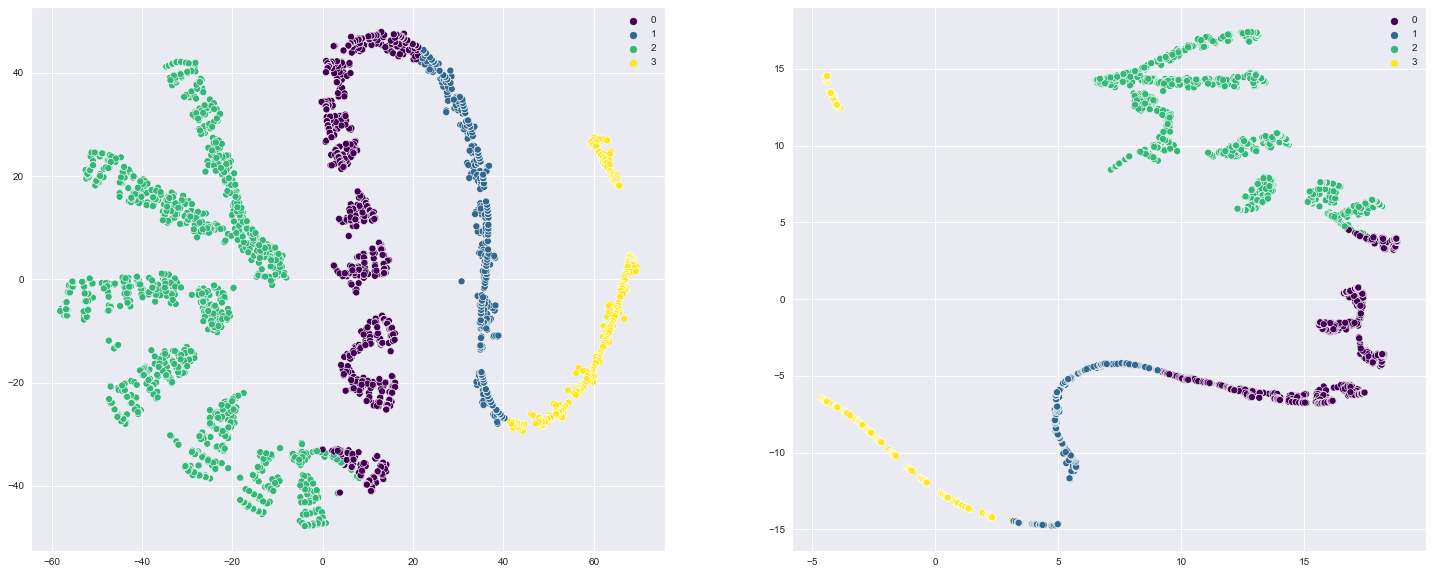

In [310]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

<AxesSubplot:>

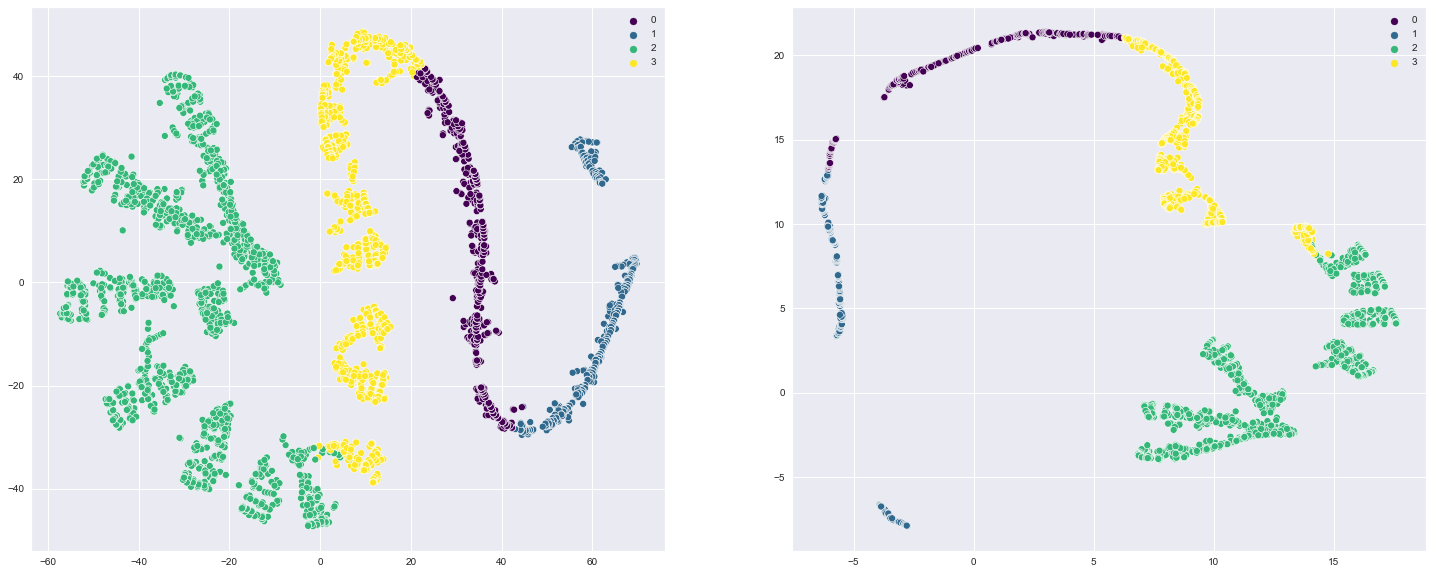

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

In [128]:
#df_fselect['cluster'] = labels_tsne

## 9.2. Clusters Profile

In [316]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['std_recency'] = cluster_df.groupby('cluster').std()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
prof['std_frequency'] = cluster_df.groupby('cluster').std()['frequency']
prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['std_monetary'] = cluster_df.groupby('cluster').std()['monetary']
#prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
#prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof['std_ticket'] = cluster_df.groupby('cluster').std()['avg_ticket']
prof

,cluster,customer_id,percentual,avg_recency,std_recency,avg_frequency,std_frequency,avg_monetary,std_monetary,avg_ticket,std_ticket
0,0,1084,25.092593,80.382841,23.998194,2.610701,2.060425,987.202860,1182.218154,30.012360,51.317914
1,1,613,14.189815,191.309951,32.378055,1.866232,1.402047,662.124845,1939.497581,51.879907,425.514083
2,2,2127,49.236111,18.704748,13.357248,6.466385,10.288166,3112.271575,11658.799864,29.532608,109.483044
3,3,496,11.481481,308.491935,39.123063,1.340726,1.671760,399.718992,599.790311,34.563391,79.062178


In [313]:
cluster_df.query('cluster==2').sort_values('monetary', ascending=False)

,customer_id,recency,frequency,monetary,avg_ticket,cluster
24923,14646,1.0,72.0,2.787780e+05,1.351979e+02,2
10893,18102,0.0,60.0,2.596573e+05,6.024531e+02,2
9825,17450,8.0,46.0,1.897355e+05,5.580457e+02,2
1399,14911,1.0,199.0,1.330071e+05,2.255888e+01,2
28710,12415,24.0,20.0,1.236382e+05,1.597393e+02,2
...,...,...,...,...,...,...
356845,15657,22.0,1.0,3.000000e+01,3.000000e+01,2
339175,16953,30.0,1.0,2.080000e+01,2.080000e+01,2
136358,16446,0.0,2.0,2.900000e+00,7.250000e-01,2
389544,12558,7.0,1.0,1.065814e-14,4.844610e-16,2


In [ ]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
#prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,total_spent,number_of_cancelations,avg_ticket
0,0,618,14.242913,191.040453,1.873786,603.412930,0.881877,34.513633
1,1,498,11.477299,308.369478,1.349398,392.575221,0.532129,32.739829
2,2,2130,49.089652,18.699061,6.497653,3127.423573,3.136620,29.271794
3,3,1093,25.190136,80.428179,2.622141,988.703744,1.213175,31.824948


In [ ]:
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,avg_monetary
0,0,418,9.633556,26.248804,12.490431,6008.355598
1,1,3,0.069140,3.000000,60.000000,244804.703333
2,2,38,0.875778,13.868421,34.947368,24694.783684
3,3,3865,89.075824,100.321863,2.840103,926.552337
4,4,15,0.345702,7.733333,55.333333,76398.306000


In [130]:
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,avg_monetary,avg_ticket
0,0,4071,93.115279,96.969295,3.641120,946.696250,25.359654
1,1,6,0.137237,7.166667,89.000000,182181.981667,253.626345
2,2,28,0.640439,6.178571,57.821429,42614.387143,162.862605
3,3,267,6.107045,20.280899,19.528090,8089.028652,62.783157


## 9.3 Report

Cluster 1

    - Number of Customers: 6
    - Percentage of Customers: 0.14%
    - Average Recency: 7.2 
    - Average Frequency: 89
    - Average Monetary: 182,181.98

Cluster 2

    - Number of Customers: 31
    - Percentage of Customers: 0.71%
    - Average Recency: 14 
    - Average Frequency: 53.3
    - Average Monetary: 40,543.52

Cluster 0

    - Number of Customers: 4335
    - Percentage of Customers: 99.15%
    - Average Recency: 92.26 
    - Average Frequency: 4.6
    - Average Monetary: 1,372.58

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 10.0. Deploy to Production